In [1]:
import habitat_sim

import random
%matplotlib inline
import matplotlib.pyplot as plt
import PyQt5
import os

import numpy as np
import json

In [2]:
test_scene = "/media/shubodh/DATA/Downloads/data-non-onedrive/replica_v1/apartment_0/habitat/mesh_semantic.ply"


sim_settings = {
    "width": 1920,  # Spatial resolution of the observations    
    "height": 1080,
    "scene": test_scene,  # Scene path
    "default_agent": 0,  
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": True,  # RGB sensor
    "semantic_sensor": True,  # Semantic sensor
    "depth_sensor": True,  # Depth sensor
    "seed": 1,
}

# Simulator config

In [3]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene.id = settings["scene"]
    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "semantic_sensor": {
            "sensor_type": habitat_sim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },  
    }
    
    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]

            sensor_specs.append(sensor_spec)
            
#             print(sensor_spec.parameters.__repr__)
    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }
    
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [4]:
cfg = make_cfg(sim_settings)
sim = habitat_sim.Simulator(cfg)

I0802 13:02:23.248319 12518 simulator.py:146] Loaded navmesh /media/shubodh/DATA/Downloads/data-non-onedrive/replica_v1/apartment_0/habitat/mesh_semantic.navmesh


In [5]:
# Try to access sensor_spec.sensor_type above first
# print(help(sim))

# Scene semantic annotations

In [6]:
def print_scene_recur(scene, limit_output=10):
    print(f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects")
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")
    
    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return None

# Print semantic annotation information (id, category, bounding box details) 
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 0 levels, 0 regions and 462 objects
House center:[0. 0. 0.] dims:[-inf -inf -inf]


In [12]:
from PIL import Image
from habitat_sim.utils.common import d3_40_colors_rgb

def display_save_sample(rgb_obs, semantic_obs, depth_obs, obs_id, save=True, visualize=False):
    # Save raw data
    if save:
        raw_data_folder = "./data_collection/apartment_0/raw_data/" 
        np.save(raw_data_folder + str(obs_id) + "_rgb",rgb_obs)
        np.save(raw_data_folder + str(obs_id) + "_instance-seg",semantic_obs)
        np.save(raw_data_folder + str(obs_id) + "_depth",depth_obs)
    
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    # Save visualization data
    if save:
        viz_data_folder = "./data_collection/apartment_0/viz_data/"
        rgb_img.save(viz_data_folder + str(obs_id) + "_rgb.png")
        semantic_img.save(viz_data_folder + str(obs_id) + "_instance-seg.png")
        depth_img.save(viz_data_folder + str(obs_id) + "_depth.png")
        print()
    # visualize first 5 frames
    if visualize and (obs_id < 5):
        arr = [rgb_img, semantic_img, depth_img]
        titles = ['rgb', 'semantic', 'depth']
        plt.figure(figsize=(12 ,8))
        for i, data in enumerate(arr):
            ax = plt.subplot(1, 3, i+1)
            ax.axis('off')
            ax.set_title(titles[i])
            plt.imshow(data, cmap='gray')
        plt.show()
    


In [13]:
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
poses_json = "/media/shubodh/DATA/OneDrive/rrc_projects/2020/DeepGlobalRegistration-Navigation/habitat_all/habitat-sim/examples/data_collection/apartment_0/poses_run-replica-apartment_0.json"
with open(poses_json) as f:
    poses_data = json.load(f)
    
    position_array = [list(map(float,i)) for i in poses_data['position']]
    rotation_array = [list(map(float,i)) for i in poses_data['rotation']]

In [ ]:
poses_path = {
    'position': np.array(position_array),
    'rotation': np.array(rotation_array)
}

agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = poses_path['position'][0]
agent_state.rotation = habitat_sim.utils.common.quat_from_coeffs(poses_path['rotation'][0])
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", (agent_state.rotation))

# Take random actions and display sensor data

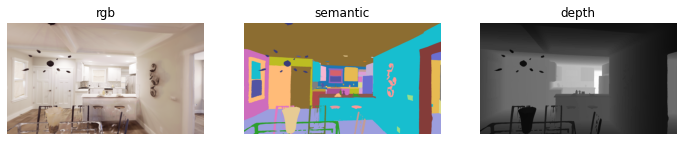

agent_state: position [ 0.284301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)


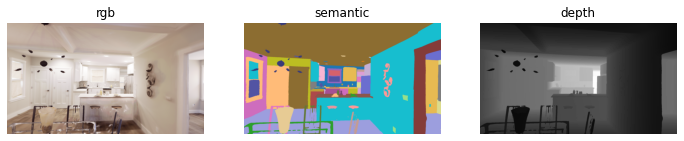

agent_state: position [ 0.384301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)


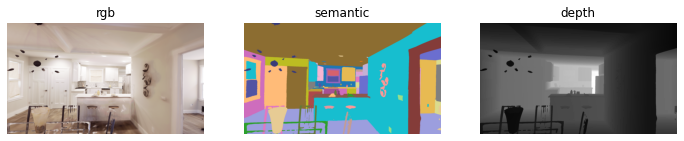

agent_state: position [ 0.484301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)


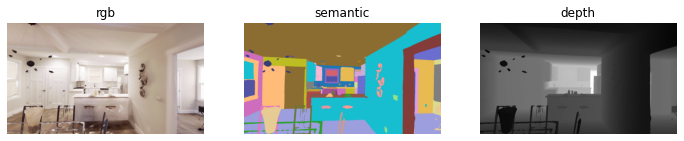

agent_state: position [ 0.584301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)


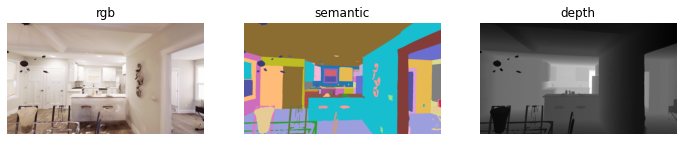

agent_state: position [ 0.684301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)


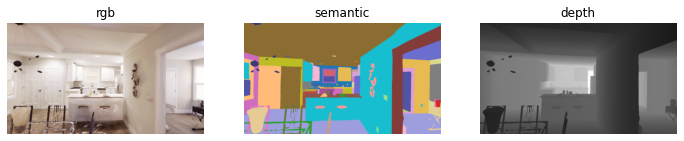

agent_state: position [ 0.784301 -1.37477   5.26595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.784301 -1.37477   5.16595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.884301 -1.37477   5.16595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   5.16595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   5.06595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.96595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.86595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.76595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.66595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.56595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.46595 ] rotation quaternion(1, 0, 0, 0)
agent_state: position [ 0.984301 -1.37477   4.36595 ] 

agent_state: position [-1.55271 -1.32363  2.88825] rotation quaternion(0.956939995288849, 0, 0.290284991264343, 0)
agent_state: position [-1.60826 -1.30445  2.8051 ] rotation quaternion(0.956939995288849, 0, 0.290284991264343, 0)
agent_state: position [-1.66382 -1.28528  2.72195] rotation quaternion(0.956939995288849, 0, 0.290284991264343, 0)
agent_state: position [-1.66382 -1.28528  2.72195] rotation quaternion(0.980785012245178, 0, 0.195089995861053, 0)
agent_state: position [-1.70209 -1.2773   2.62957] rotation quaternion(0.980785012245178, 0, 0.195089995861053, 0)
agent_state: position [-1.70209 -1.2773   2.62957] rotation quaternion(0.995185017585754, 0, 0.0980170965194702, 0)
agent_state: position [-1.7216  -1.27667  2.53149] rotation quaternion(0.995185017585754, 0, 0.0980170965194702, 0)
agent_state: position [-1.74111 -1.27604  2.43341] rotation quaternion(0.995185017585754, 0, 0.0980170965194702, 0)
agent_state: position [-1.74111 -1.27604  2.43341] rotation quaternion(1, 0, 

In [19]:
total_frames = 0
action_names = list(
    cfg.agents[
        sim_settings["default_agent"]
    ].action_space.keys()
)

images_for_video = []

max_frames = 100 #len(poses_path['position'])
while total_frames < max_frames:
#     action = random.choice(action_names)
#     print("action", action)
    agent_state.position = poses_path['position'][total_frames]
    agent_state.rotation = habitat_sim.utils.common.quat_from_coeffs(poses_path['rotation'][total_frames])
    agent.set_state(agent_state)
    
    observations = sim.get_sensor_observations()
#     print((observations))
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]
    
    images_for_video.append(rgb)
    
    display_save_sample(rgb, semantic, depth, total_frames, save=False, visualize=False)
    
    agent_state = agent.get_state()
    print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

    total_frames += 1

In [22]:
import imageio
import tqdm
from habitat.core.logging import logger
from typing import Dict, List, Optional, Tuple


def img_to_video(images: List[np.ndarray],
                output_dir: str,
                video_name: str,
                fps: int = 30,
                quality: Optional[float] = 5,
                **kwargs,):
    
    assert 0 <= quality <= 10
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    video_name = video_name.replace(" ", "_").replace("\n", "_") + ".mp4"
    writer = imageio.get_writer(
        os.path.join(output_dir, video_name),
        fps=fps,
        quality=quality,
        **kwargs,
    )
    logger.info(f"Video created: {os.path.join(output_dir, video_name)}")
    for im in tqdm.tqdm(images):
        writer.append_data(im)
    writer.close()

In [23]:
img_to_video(images_for_video, './data_collection/apartment_0/', 'data_run_video')

2020-08-02 13:21:29,486 Video created: ./data_collection/apartment_0/data_run_video.mp4
100%|██████████| 100/100 [00:02<00:00, 41.97it/s]
